In [1]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip #Download the data from
!unzip hymenoptera_data.zip #extract it to the current directory.

--2020-01-15 16:21:53--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.222.155.25, 52.222.155.103, 52.222.155.217, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.222.155.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.2’

hymenoptera_data.zi 100%[===================>]  45,10M  53,4MB/s    in 0,8s    

2020-01-15 16:21:54 (53,4 MB/s) - ‘hymenoptera_data.zip.2’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [11]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 

In [20]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Data set'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

avDev = torch.device("cuda:0")

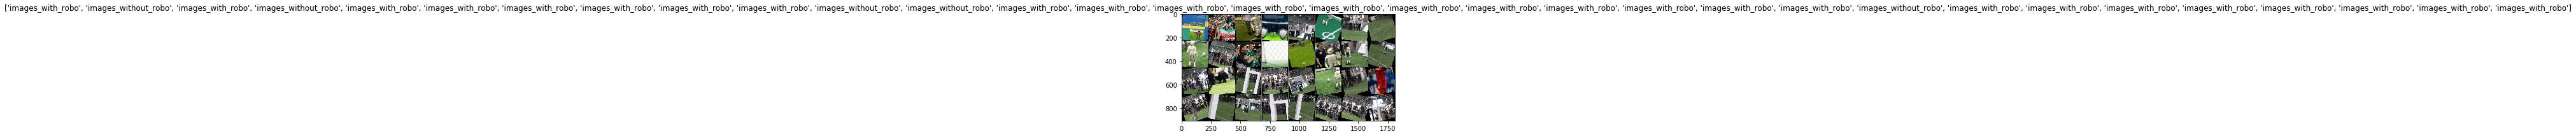

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(avDev)
#                 labels = labels.to(avDev)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        
        inputs, labels = inputs.to(avDev), labels.to(avDev)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu()[j])

            if images_so_far == num_images:
                return

In [18]:
model_ft = models.densenet121(pretrained=True,memory_efficient=True) # check: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(avDev)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3174 Acc: 0.8779
val Loss: 0.3373 Acc: 0.8839

Epoch 1/24
----------
train Loss: 0.2796 Acc: 0.8905
val Loss: 0.3385 Acc: 0.8750

Epoch 2/24
----------
train Loss: 0.2720 Acc: 0.8979
val Loss: 0.3439 Acc: 0.8750

Epoch 3/24
----------
train Loss: 0.2604 Acc: 0.8842
val Loss: 0.3426 Acc: 0.8839

Epoch 4/24
----------
train Loss: 0.2579 Acc: 0.8863
val Loss: 0.3411 Acc: 0.8750

Epoch 5/24
----------
train Loss: 0.2522 Acc: 0.8916
val Loss: 0.3380 Acc: 0.8750

Epoch 6/24
----------
train Loss: 0.2705 Acc: 0.8884
val Loss: 0.3296 Acc: 0.8839

Epoch 7/24
----------
train Loss: 0.2258 Acc: 0.9042
val Loss: 0.3211 Acc: 0.8929

Epoch 8/24
----------
train Loss: 0.2327 Acc: 0.9074
val Loss: 0.3360 Acc: 0.8839

Epoch 9/24
----------
train Loss: 0.2408 Acc: 0.9000
val Loss: 0.3318 Acc: 0.8929

Epoch 10/24
----------
